In [1]:
import pandas as pd
import numpy as np
import os
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LogisticRegression, LassoCV, LinearRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import bootstrap
from src.utils.data import getDataPandas, getConfig
from pipe.lut import Model_LUT, Metrics_LUT, Feature_LUT, Plot_LUT
from pipe.stats import stats_analyze
from mrmr import mrmr_classif, mrmr_regression
import sys
from io import StringIO

In [2]:
# None-image features
data = getDataPandas()
model_config = getConfig('model')
data_config = getConfig('data')
img_config = getConfig('image')
group = data_config['data_group']

# Tasks include models used
TASKS = [
    #'classification/10',
    #'regression',
    #'classification/2',
    'logistic/2'
]
# Features include image features used
FEATURES = [
    ['tiv_gmv', 't1_radiomic'],
]

# Maybe write to a specific file later?
log_func = print
rst = {}
auc_dist = {}

Current Task: logistic/2

Image Features:
 ['tiv_gmv', 't1_radiomic']

SEX chi2 p: 0.5414803876006902
CAT chi2 p: 0.9510706628888684
AGE_AT_VISIT Normaltest p_train: [0.07505303], p_test: [0.48389882]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([1.54953415]), pvalue=array([0.12271054]))
NUPDR3OF Normaltest p_train: [0.01407325], p_test: [0.53859285]
NUPDR3OF ranksums p: RanksumsResult(statistic=array([0.53408144]), pvalue=array([0.59328519]))
LEDD Normaltest p_train: [2.56158925e-12], p_test: [0.1798008]
LEDD ranksums p: RanksumsResult(statistic=array([0.51837316]), pvalue=array([0.60419794]))
DURATION Normaltest p_train: [0.00553476], p_test: [0.13860719]
DURATION ranksums p: RanksumsResult(statistic=array([-0.45554005]), pvalue=array([0.64872076]))



100%|██████████| 50/50 [00:01<00:00, 29.94it/s]


0.010779131700049188


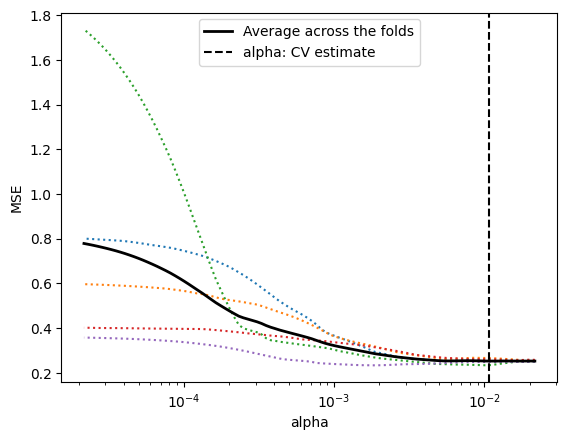

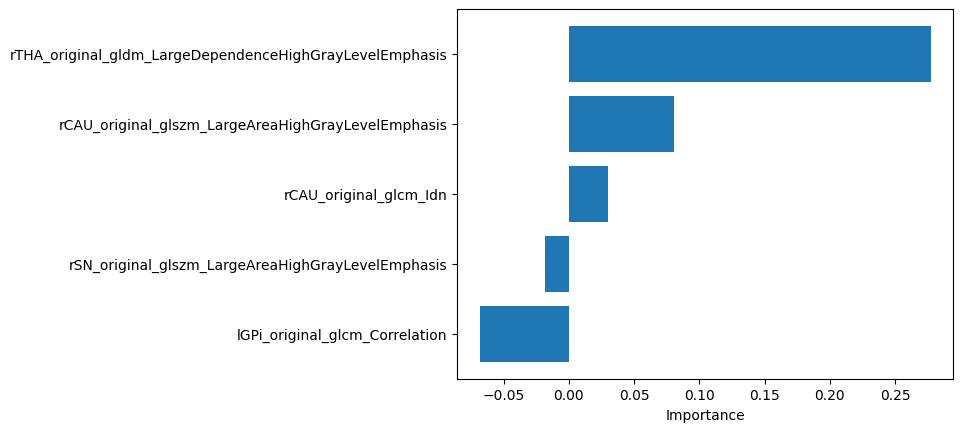

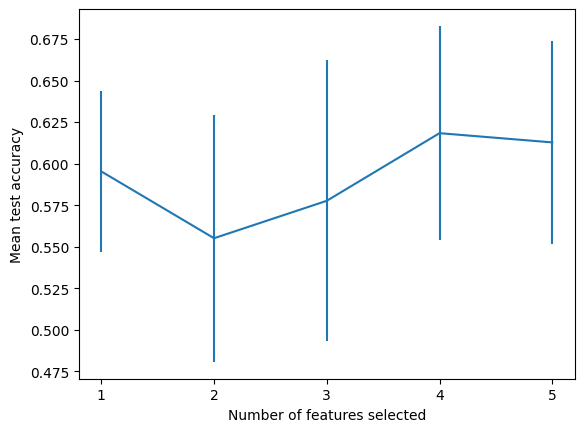

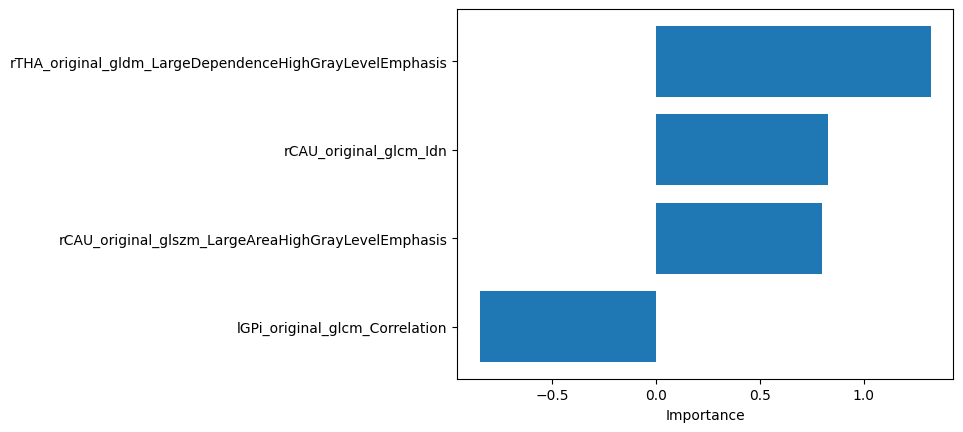

Selected features: ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis'
 'lGPi_original_glcm_Correlation'
 'rCAU_original_glszm_LargeAreaHighGrayLevelEmphasis'
 'rCAU_original_glcm_Idn']

Demo + Clinic:



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29225723
Epoch 3, change: 0.11963141
convergence after 17 epochs took 0 seconds
Model: logistic
Epoch 4, change: 0.04595594
Epoch 5, change: 0.06655725
Epoch 6, change: 0.04427718
Epoch 7, change: 0.01351906
Epoch 8, change: 0.01031977
Epoch 9, change: 0.00307965
Epoch 10, change: 0.00356075
Epoch 11, change: 0.00349741
Epoch 12, change: 0.00162596
Epoch 13, change: 0.00073258
Epoch 14, change: 0.00048368
Epoch 15, change: 0.00026911
Epoch 16, change: 0.00019551
AUC train 0.7089013632718525 ci ConfidenceInterval(low=0.625752441837531, high=0.7788109919253513)
AUC test 0.7462121212121211 ci ConfidenceInterval(low=0.5870588024794567, high=0.8742706388122488)
(46, 2)


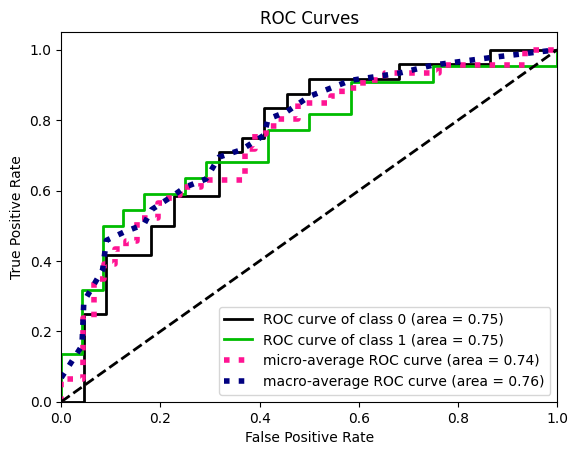

(46,)


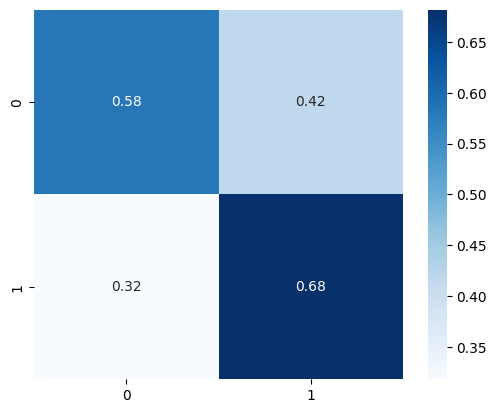


Demo + Clinic + Img:

Epoch 1, change: 1.00000000
Epoch 2, change: 0.23124576
Epoch 3, change: 0.15557127
Epoch 4, change: 0.05765511
Epoch 5, change: 0.06180663
Epoch 6, change: 0.03776674
Epoch 7, change: 0.02431807
Epoch 8, change: 0.02078094
Epoch 9, change: 0.01619513
Epoch 10, change: 0.01078898
Epoch 11, change: 0.00988686
Epoch 12, change: 0.00879270
Epoch 13, change: 0.00727859
Epoch 14, change: 0.00518774
Epoch 15, change: 0.00476730
Epoch 16, change: 0.00429269
Epoch 17, change: 0.00360493
Epoch 18, change: 0.00285454
Epoch 19, change: 0.00224625
Epoch 20, change: 0.00198159
Epoch 21, change: 0.00169062
Epoch 22, change: 0.00134350
Epoch 23, change: 0.00113820
Epoch 24, change: 0.00091997
Epoch 25, change: 0.00082264
Epoch 26, change: 0.00066038
Epoch 27, change: 0.00056667
Epoch 28, change: 0.00045158
Epoch 29, change: 0.00036284
Epoch 30, change: 0.00037050
Epoch 31, change: 0.00022583
Epoch 32, change: 0.00020741
Epoch 33, change: 0.00018662
Epoch 34, change: 0.00014621


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


AUC train 0.7675755145682972 ci ConfidenceInterval(low=0.6953844590412503, high=0.831317547062046)
AUC test 0.7518939393939394 ci ConfidenceInterval(low=0.6076727072244286, high=0.875)
(46, 2)


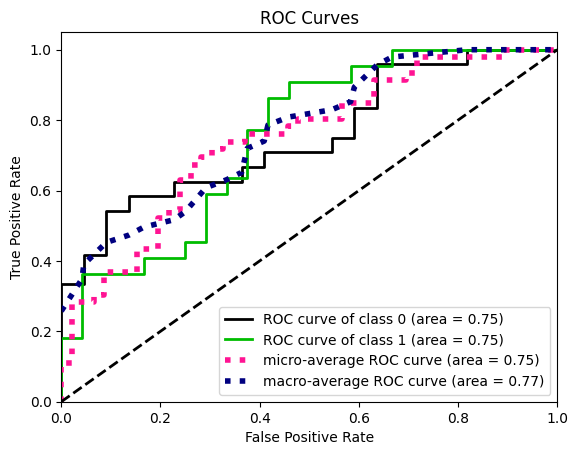

(46,)


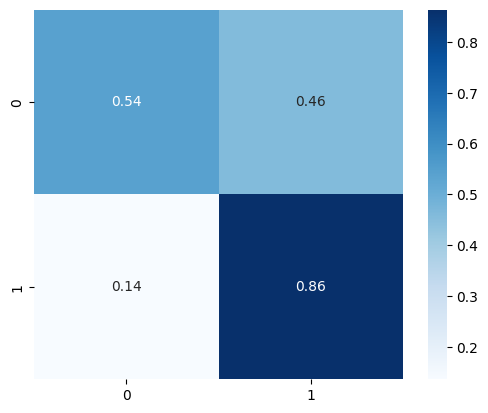

In [3]:
# Loop for tasks and feature collections
for task_name in TASKS:
    log_func('Current Task: {}'.format(task_name))
    log_func()
    for feature_names in FEATURES:
        log_func('Image Features:\n {}'.format(feature_names))
        log_func()
        # Get model list
        task = model_config['task'][task_name]
        models = task['models']
        metric_list = task['metrics']
        
        # Filter data with demographic and clinical keys
        x = data[group['demo'] + group['clinic']]
        y = data[[task['output']]]
        # Split the dataset
        train_inds = data_config['train_index']
        test_inds = data_config['test_index']
        x_clinic_train = x.iloc[train_inds].reset_index(drop=True)
        x_clinic_test = x.iloc[test_inds].reset_index(drop=True)
        y_train = y.iloc[train_inds].reset_index(drop=True)
        y_test = y.iloc[test_inds].reset_index(drop=True)
        # Statistical Analysis
        stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
        # Empty dataframes to fill with image features
        x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
        x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

        # Loop to calculate each feature, multiple features are supported
        for feature_name in feature_names:
            # Get calculation function and params via LUT
            func = Feature_LUT[feature_name]
            params = img_config['task'][feature_name]['params']
            # Calculate features and append to the dataframe
            x_fe_train, x_fe_test = func(data, train_inds, test_inds, params)
            x_img_train = x_img_train.join(x_fe_train.reset_index(drop=True))
            x_img_test = x_img_test.join(x_fe_test.reset_index(drop=True))

        # Normalization
        scaler = MinMaxScaler()
        x_img_train = pd.DataFrame(scaler.fit_transform(x_img_train, y_train), columns=x_img_train.columns)
        x_img_test = pd.DataFrame(scaler.transform(x_img_test), columns=x_img_test.columns)
        
        ## Feature Selection
        ## WIP
        
        isContinuous = task['continuous']
        
        ##mRMR
        selected = mrmr_classif(X=x_img_train, y=y_train, K=50) if not isContinuous else mrmr_regression(X=x_img_train, y=y_train, K=50)
        ##LASSO for classification?
        la = LassoCV(cv=5, random_state=1, max_iter=10000)
        la.fit(x_img_train[selected], y_train)
        print(la.alpha_)
        plt.semilogx(la.alphas_, la.mse_path_, ':')
        plt.plot(
            la.alphas_ ,
            la.mse_path_.mean(axis=-1),
            "k",
            label="Average across the folds",
            linewidth=2,
        )
        plt.axvline(
            la.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
        )
        plt.legend()
        plt.ylabel('MSE')
        plt.xlabel('alpha')
        plt.show()
        la = Lasso(alpha=la.alpha_)
        la.fit(x_img_train[selected], y_train)
        selected = np.array(selected)[np.abs(la.coef_)>0]
        coef = np.array(la.coef_)[np.abs(la.coef_)>0]
        sort_idx = coef.argsort()
        plt.barh(selected[sort_idx], coef[sort_idx])
        plt.xlabel('Importance')
        plt.show()
        #selected = selected[:2]
        
        #est = LogisticRegression(penalty='elasticnet', solver='saga', random_state=1, l1_ratio=0.5)
        #est = LogisticRegression(penalty='l1', solver='saga', random_state=1)
        est = LogisticRegression(random_state=1)
        selector = RFECV(est, min_features_to_select=1, cv=5, step=1)
        selector = selector.fit(X=x_img_train[selected], y=y_train)
        selected = np.array(selected)[selector.get_support()]
        n_scores = len(selector.cv_results_["mean_test_score"])
        plt.errorbar(
            range(1, n_scores+1),
            selector.cv_results_["mean_test_score"],
            yerr=selector.cv_results_["std_test_score"],
        )
        plt.xticks(range(1,n_scores+1))
        plt.xlabel("Number of features selected")
        plt.ylabel("Mean test accuracy")
        plt.show()
        coef = selector.estimator_.coef_[0]
        sort_idx = coef.argsort()
        plt.barh(selected[sort_idx], coef[sort_idx])
        plt.xlabel('Importance')
        plt.show()
        #selector = selector.fit(X=x_img_train, y=y_train)
        #selected = np.array(x_img_train.columns)[selector.get_support()]

        
        log_func('Selected features: {}'.format(selected))
        log_func()
        x_img_train = x_img_train[selected]
        x_img_test = x_img_test[selected]

        # Rearrange data
        # demo + clinic, demo + img, demo + clinic + img
        x_clinic_train = x_clinic_train.reset_index(drop=True)
        x_clinic_test = x_clinic_test.reset_index(drop=True)
        x_demo_train = x_clinic_train[group['demo']]
        x_demo_test = x_clinic_test[group['demo']]
        x_clinic_img_train = x_clinic_train.join(x_img_train)
        x_clinic_img_test = x_clinic_test.join(x_img_test)
        # No demo data in img df
        x_img_train = x_demo_train.join(x_img_train)
        x_img_test = x_demo_test.join(x_img_test)

        x_train_list = [x_clinic_train, x_clinic_img_train]
        x_test_list = [x_clinic_test, x_clinic_img_test]
        info_list = ['Demo + Clinic:', 'Demo + Clinic + Img:']
        
        #x_train_list = [x_clinic_img_train]
        #x_test_list = [x_clinic_img_test]
        #info_list = ['Demo + Clinic + Img:']

        # Loop
        for i in range(len(info_list)):
            x_train = x_train_list[i]
            x_test = x_test_list[i]
            scaler = MinMaxScaler()
            x_train = pd.DataFrame(scaler.fit_transform(x_train, y_train), columns=x_train.columns)
            x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
            log_func(info_list[i])
            log_func()
            for model in models:
                name = model['name']
                parameters = model['params']
                model = Model_LUT[name]
                cv = GridSearchCV(
                    model(),
                    parameters,
                    n_jobs=5,
                    # StratifiedGroupKFold?
                    cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                    scoring=task['gridsearch_params']['scoring']
                )

                cv.fit(x_train, y_train.values.ravel())
                model_instance = model(**cv.best_params_, verbose=3)
                model_instance.fit(x_train, y_train.values.ravel())
                
                log_func('Model: {}'.format(name))
                # Now classification specific, other metrics need to be considered according to task
                for metric in metric_list:
                    metric_func = Metrics_LUT[metric[0]]
                    # predict_proba True
                    # predic        False
                    pred_func = model_instance.predict_proba if metric[1] else model_instance.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    
                    # CI
                    from sklearn import metrics
                    y_train_np = y_train[task['output']].to_numpy()
                    y_test_np = y_test[task['output']].to_numpy()
                    ci_train = bootstrap((y_train_np, train_pred[:, 1]), statistic=metrics.roc_auc_score, n_resamples=1000, paired=True, random_state=1)
                    ci_test = bootstrap((y_test_np, test_pred[:, 1]), statistic=metrics.roc_auc_score, n_resamples=1000, paired=True, random_state=1)
                    
                    log_func('{} train {} ci {}'.format(metric[0],
                                                           metric_func(y_train_np, train_pred),
                                                           ci_train.confidence_interval
                                                           ))
                    log_func('{} test {} ci {}'.format(metric[0],
                                                           metric_func(y_test_np, test_pred),
                                                           ci_test.confidence_interval
                                                           ))
                    auc_dist[info_list[i]+name] = ci_test.bootstrap_distribution
                plot_list = task['plot']
                for plot in plot_list:
                    plot_func = Plot_LUT[plot[0]]
                    pred_func = model_instance.predict_proba if plot[1] else model_instance.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    plot_func(y_test[task['output']].to_numpy(), test_pred)
                    plt.show()
                #coef = model_instance.coef_[0]
                #sort_idx = coef.argsort()
                #plt.barh(x_train.columns[sort_idx], coef[sort_idx])
                #plt.xlabel('Importance')
                #plt.show()
            log_func()

Current Task: regression

Image Features:
 ['tiv_gmv', 't1_radiomic']

SEX chi2 p: 0.5414803876006902
AGE_AT_VISIT Normaltest p_train: [0.07505303], p_test: [0.48389882]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([1.54953415]), pvalue=array([0.12271054]))
NUPDR3OF Normaltest p_train: [0.01407325], p_test: [0.53859285]
NUPDR3OF ranksums p: RanksumsResult(statistic=array([0.53408144]), pvalue=array([0.59328519]))
LEDD Normaltest p_train: [2.56158925e-12], p_test: [0.1798008]
LEDD ranksums p: RanksumsResult(statistic=array([0.51837316]), pvalue=array([0.60419794]))
DURATION Normaltest p_train: [0.00553476], p_test: [0.13860719]
DURATION ranksums p: RanksumsResult(statistic=array([-0.45554005]), pvalue=array([0.64872076]))
SCORE Normaltest p_train: [0.11066874], p_test: [0.39032482]
SCORE t-test p: Ttest_indResult(statistic=array([-0.76164065]), pvalue=array([0.44710146]))



100%|██████████| 50/50 [00:01<00:00, 29.52it/s]


0.007042084650758803


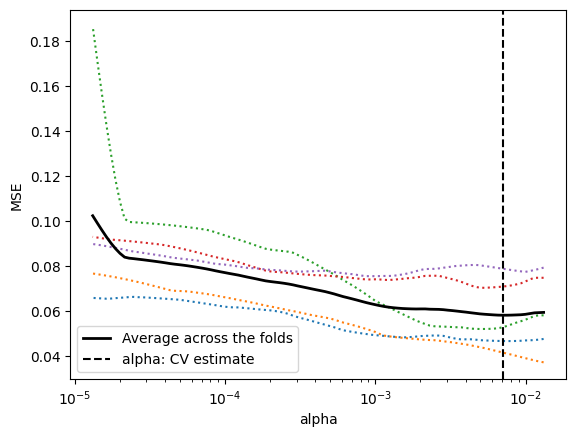

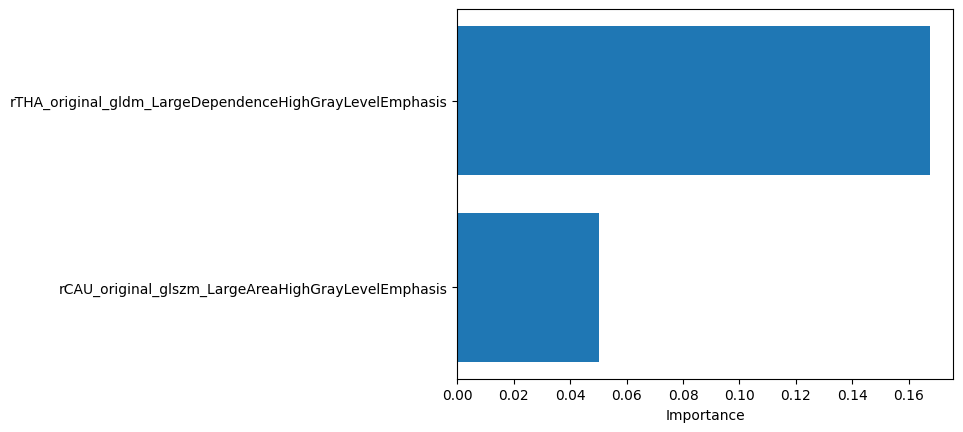

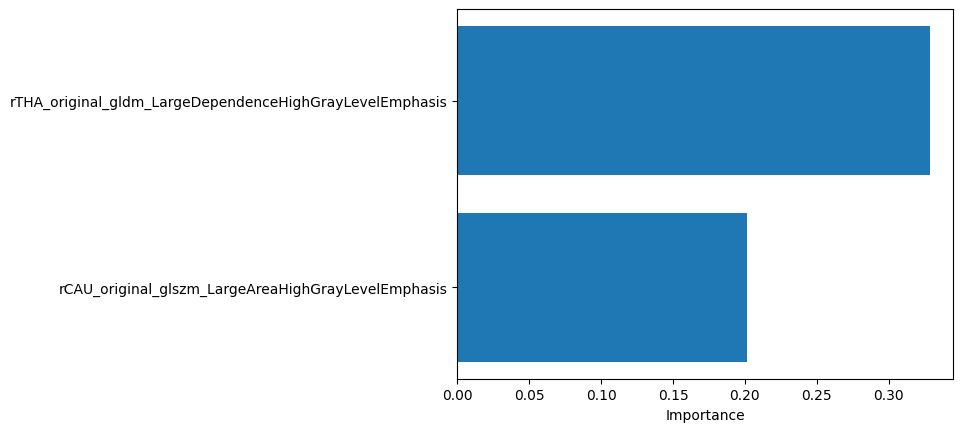

Selected features: ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis'
 'rCAU_original_glszm_LargeAreaHighGrayLevelEmphasis']

Demo + Clinic:

Model: linear
r2 train 0.12120336945215149
r2 test 0.11278292309329119


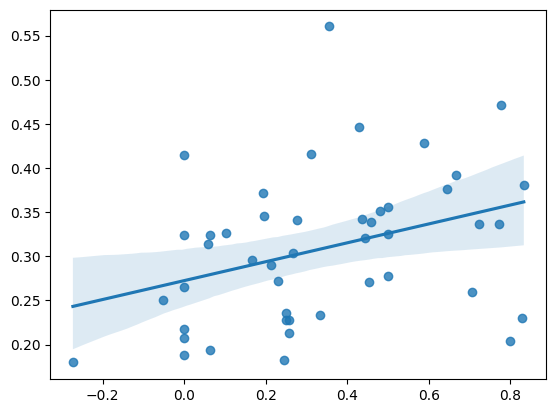

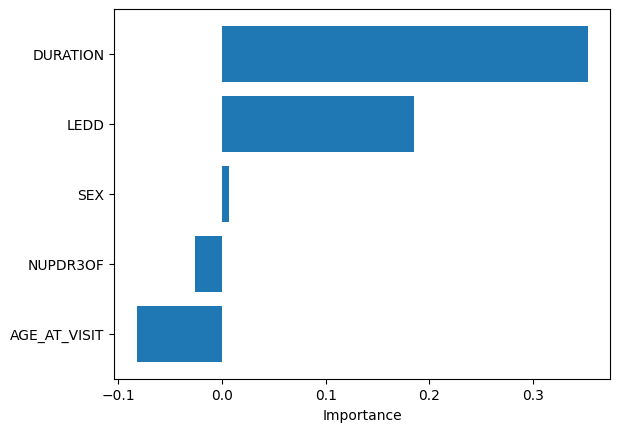


Demo + Clinic + Img:

Model: linear
r2 train 0.2223465808625501
r2 test 0.2354706131137857


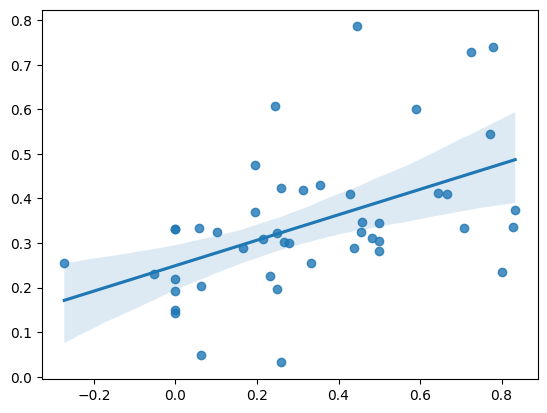

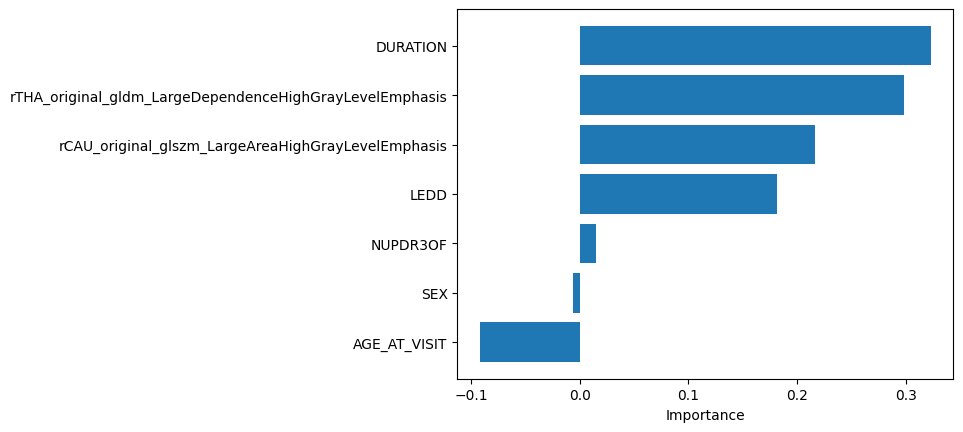

In [ ]:
# Loop for tasks and feature collections
for task_name in TASKS:
    log_func('Current Task: {}'.format(task_name))
    log_func()
    for feature_names in FEATURES:
        log_func('Image Features:\n {}'.format(feature_names))
        log_func()
        # Get model list
        task = model_config['task'][task_name]
        models = task['models']
        metric_list = task['metrics']
        
        # Filter data with demographic and clinical keys
        x = data[group['demo'] + group['clinic']]
        y = data[[task['output']]]
        # Split the dataset
        train_inds = data_config['train_index']
        test_inds = data_config['test_index']
        x_clinic_train = x.iloc[train_inds].reset_index(drop=True)
        x_clinic_test = x.iloc[test_inds].reset_index(drop=True)
        y_train = y.iloc[train_inds].reset_index(drop=True)
        y_test = y.iloc[test_inds].reset_index(drop=True)
        # Statistical Analysis
        stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
        # Empty dataframes to fill with image features
        x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
        x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

        # Loop to calculate each feature, multiple features are supported
        for feature_name in feature_names:
            # Get calculation function and params via LUT
            func = Feature_LUT[feature_name]
            params = img_config['task'][feature_name]['params']
            # Calculate features and append to the dataframe
            x_fe_train, x_fe_test = func(data, train_inds, test_inds, params)
            x_img_train = x_img_train.join(x_fe_train.reset_index(drop=True))
            x_img_test = x_img_test.join(x_fe_test.reset_index(drop=True))

        # Normalization
        scaler = MinMaxScaler()
        x_img_train = pd.DataFrame(scaler.fit_transform(x_img_train, y_train), columns=x_img_train.columns)
        x_img_test = pd.DataFrame(scaler.transform(x_img_test), columns=x_img_test.columns)
        
        ## Feature Selection
        ## WIP
        
        isContinuous = task['continuous']
        
        ##mRMR
        selected = mrmr_classif(X=x_img_train, y=y_train, K=50) if not isContinuous else mrmr_regression(X=x_img_train, y=y_train, K=50)
        ##LASSO for classification?
        la = LassoCV(cv=5, random_state=1, max_iter=10000)
        la.fit(x_img_train[selected], y_train)
        print(la.alpha_)
        plt.semilogx(la.alphas_, la.mse_path_, ':')
        plt.plot(
            la.alphas_ ,
            la.mse_path_.mean(axis=-1),
            "k",
            label="Average across the folds",
            linewidth=2,
        )
        plt.axvline(
            la.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
        )
        plt.legend()
        plt.ylabel('MSE')
        plt.xlabel('alpha')
        plt.show()
        la = Lasso(alpha=la.alpha_)
        la.fit(x_img_train[selected], y_train)
        selected = np.array(selected)[np.abs(la.coef_)>0]
        coef = np.array(la.coef_)[np.abs(la.coef_)>0]
        sort_idx = coef.argsort()
        plt.barh(selected[sort_idx], coef[sort_idx])
        plt.xlabel('Importance')
        plt.show()
        
        #est = LogisticRegression(penalty='elasticnet', solver='saga', random_state=1, l1_ratio=0.5)
        #est = LogisticRegression(penalty='l1', solver='saga', random_state=1)
        est = LinearRegression()
        selector = RFECV(est, min_features_to_select=1, cv=5, step=1)
        selector = selector.fit(X=x_img_train[selected], y=y_train)
        selected = np.array(selected)[selector.get_support()]
        coef = selector.estimator_.coef_[0]
        sort_idx = coef.argsort()
        plt.barh(selected[sort_idx], coef[sort_idx])
        plt.xlabel('Importance')
        plt.show()
        #selector = selector.fit(X=x_img_train, y=y_train)
        #selected = np.array(x_img_train.columns)[selector.get_support()]

        
        log_func('Selected features: {}'.format(selected))
        log_func()
        x_img_train = x_img_train[selected]
        x_img_test = x_img_test[selected]

        # Rearrange data
        # demo + clinic, demo + img, demo + clinic + img
        x_clinic_train = x_clinic_train.reset_index(drop=True)
        x_clinic_test = x_clinic_test.reset_index(drop=True)
        x_demo_train = x_clinic_train[group['demo']]
        x_demo_test = x_clinic_test[group['demo']]
        x_clinic_img_train = x_clinic_train.join(x_img_train)
        x_clinic_img_test = x_clinic_test.join(x_img_test)
        # No demo data in img df
        x_img_train = x_demo_train.join(x_img_train)
        x_img_test = x_demo_test.join(x_img_test)

        x_train_list = [x_clinic_train, x_clinic_img_train]
        x_test_list = [x_clinic_test, x_clinic_img_test]
        info_list = ['Demo + Clinic:', 'Demo + Clinic + Img:']
        
        #x_train_list = [x_clinic_img_train]
        #x_test_list = [x_clinic_img_test]
        #info_list = ['Demo + Clinic + Img:']

        # Loop
        for i in range(len(info_list)):
            x_train = x_train_list[i]
            x_test = x_test_list[i]
            scaler = MinMaxScaler()
            x_train = pd.DataFrame(scaler.fit_transform(x_train, y_train), columns=x_train.columns)
            x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
            log_func(info_list[i])
            log_func()
            for model in models:
                name = model['name']
                parameters = model['params']
                model = Model_LUT[name]
                cv = GridSearchCV(
                    model(),
                    parameters,
                    n_jobs=5,
                    # StratifiedGroupKFold?
                    cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                    scoring=task['gridsearch_params']['scoring']
                )
                cv.fit(x_train, y_train.values.ravel())
                model_instance = model(**cv.best_params_)
                model_instance.fit(x_train, y_train.values.ravel())
                log_func('Model: {}'.format(name))
                # Now classification specific, other metrics need to be considered according to task
                for metric in metric_list:
                    metric_func = Metrics_LUT[metric[0]]
                    # predict_proba True
                    # predic        False
                    pred_func = model_instance.predict_proba if metric[1] else model_instance.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    
                    y_train_np = y_train[task['output']].to_numpy()
                    y_test_np = y_test[task['output']].to_numpy()
                    
                    log_func('{} train {}'.format(metric[0],
                                                  metric_func(y_train, train_pred)
                                                  ))
                    log_func('{} test {}'.format(metric[0],
                                                 metric_func(y_test, test_pred)
                                                 ))
                plot_list = task['plot']
                for plot in plot_list:
                    plot_func = Plot_LUT[plot[0]]
                    pred_func = model_instance.predict_proba if plot[1] else model_instance.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    plot_func(y_test[task['output']].to_numpy(), test_pred)
                    plt.show()
                coef = model_instance.coef_
                sort_idx = coef.argsort()
                plt.barh(x_train.columns[sort_idx], coef[sort_idx])
                plt.xlabel('Importance')
                plt.show()
            log_func()

In [ ]:
coef

-0.08239140696954127

In [ ]:
from scipy.stats import ttest_ind
print(ttest_ind(auc_dist['Demo + Clinic + Img:logistic'], auc_dist['Demo + Clinic:logistic'], alternative='greater').pvalue)
print(ttest_ind(auc_dist['Demo + Clinic + Img:svc'], auc_dist['Demo + Clinic:svc'], alternative='greater').pvalue)
print(ttest_ind(auc_dist['Demo + Clinic + Img:xgboost'], auc_dist['Demo + Clinic:xgboost'], alternative='greater').pvalue)

0.011739287980170808
4.765242682745555e-60
1.5845429371873796e-82


In [ ]:
len(y_train[y_train['CAT']==1])

86

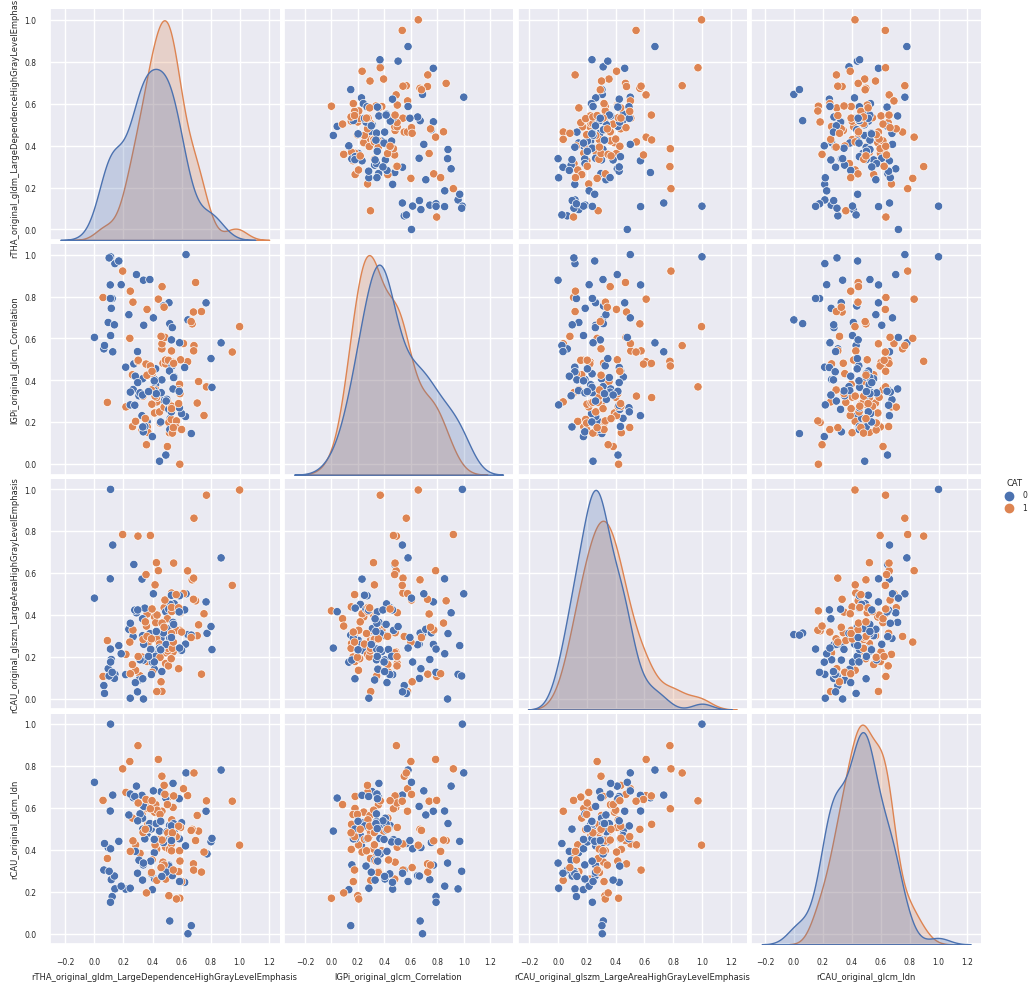

In [ ]:
ana_data = x_clinic_img_train
ana_data['CAT'] = y_train['CAT']
import seaborn as sns
sns.set(font_scale=0.5)
sns.pairplot(ana_data[list(selected)+['CAT']], hue='CAT')

<AxesSubplot: xlabel='AGE_AT_VISIT', ylabel='SCORE'>

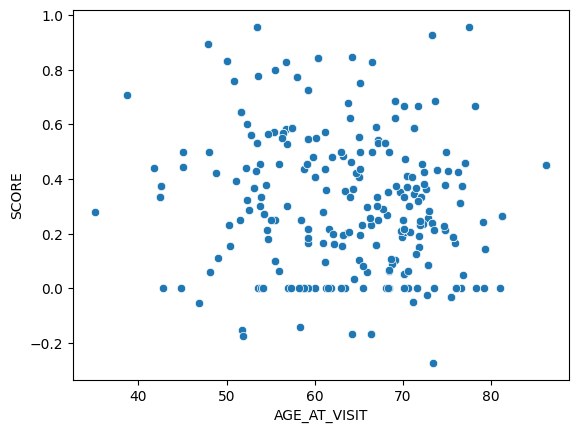

In [ ]:
import seaborn as sns
sns.scatterplot(x=data['AGE_AT_VISIT'], y=data['SCORE'])

In [22]:
# Loop for tasks and feature collections
for task_name in TASKS:
    log_func('Current Task: {}'.format(task_name))
    log_func()
    for feature_names in FEATURES:
        log_func('Image Features:\n {}'.format(feature_names))
        log_func()
        # Get model list
        task = model_config['task'][task_name]
        models = task['models']
        metric_list = task['metrics']
        
        # Filter data with demographic and clinical keys
        x = data[group['demo'] + group['clinic']]
        y = data[[task['output']]]
        # Split the dataset
        train_inds = data_config['train_index']
        test_inds = data_config['test_index']
        x_clinic_train = x.iloc[train_inds].reset_index(drop=True)
        x_clinic_test = x.iloc[test_inds].reset_index(drop=True)
        y_train = y.iloc[train_inds].reset_index(drop=True)
        y_test = y.iloc[test_inds].reset_index(drop=True)
        # Statistical Analysis
        stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
        # Empty dataframes to fill with image features
        x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
        x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

        # Loop to calculate each feature, multiple features are supported
        for feature_name in feature_names:
            # Get calculation function and params via LUT
            func = Feature_LUT[feature_name]
            params = img_config['task'][feature_name]['params']
            # Calculate features and append to the dataframe
            x_fe_train, x_fe_test = func(data, train_inds, test_inds, params)
            x_img_train = x_img_train.join(x_fe_train.reset_index(drop=True))
            x_img_test = x_img_test.join(x_fe_test.reset_index(drop=True))

        # Normalization
        scaler = MinMaxScaler()
        x_img_train = pd.DataFrame(scaler.fit_transform(x_img_train, y_train), columns=x_img_train.columns)
        x_img_test = pd.DataFrame(scaler.transform(x_img_test), columns=x_img_test.columns)
        
        ## Feature Selection
        ## WIP
        
        isContinuous = task['continuous']
        
        ##mRMR
        selected = mrmr_classif(X=x_img_train, y=y_train, K=50) if not isContinuous else mrmr_regression(X=x_img_train, y=y_train, K=50)
        ##LASSO for classification?
        #la = LassoCV(cv=5, random_state=1, max_iter=10000)
        #la.fit(x_img_train[selected], y_train)
        #la = Lasso(alpha=la.alpha_)
        #la.fit(x_img_train[selected], y_train)
        #selected = np.array(selected)[np.abs(la.coef_)>0]
        #coef = np.array(la.coef_)[np.abs(la.coef_)>0]
        #sort_idx = coef.argsort()
        #selected = selected[:2]
        
        #est = LogisticRegression(penalty='elasticnet', solver='saga', random_state=1, l1_ratio=0.5)
        #est = LogisticRegression(penalty='l1', solver='saga', random_state=1)
        #est = LogisticRegression(random_state=1)
        #selector = RFECV(est, min_features_to_select=1, cv=5, step=1)
        #selector = selector.fit(X=x_img_train[selected], y=y_train)
        #selected = np.array(selected)[selector.get_support()]
        #selector = selector.fit(X=x_img_train, y=y_train)
        #selected = np.array(x_img_train.columns)[selector.get_support()]

        
        log_func('Selected features: {}'.format(selected))
        log_func()
        x_img_train = x_img_train[selected]
        x_img_test = x_img_test[selected]

        # Rearrange data
        # demo + clinic, demo + img, demo + clinic + img
        x_clinic_train = x_clinic_train.reset_index(drop=True)
        x_clinic_test = x_clinic_test.reset_index(drop=True)
        x_demo_train = x_clinic_train[group['demo']]
        x_demo_test = x_clinic_test[group['demo']]
        x_clinic_img_train = x_clinic_train.join(x_img_train)
        x_clinic_img_test = x_clinic_test.join(x_img_test)
        # No demo data in img df
        x_img_train = x_demo_train.join(x_img_train)
        x_img_test = x_demo_test.join(x_img_test)

        x_train_list = [x_clinic_train, x_clinic_img_train]
        x_test_list = [x_clinic_test, x_clinic_img_test]
        info_list = ['Demo + Clinic:', 'Demo + Clinic + Img:']
        
        #x_train_list = [x_clinic_img_train]
        #x_test_list = [x_clinic_img_test]
        #info_list = ['Demo + Clinic + Img:']

        # Loop
        train_score = [[], []]
        for i in range(len(info_list)):
            for iteration in range(1, 101):
                x_train = x_train_list[i]
                x_test = x_test_list[i]
                scaler = MinMaxScaler()
                x_train = pd.DataFrame(scaler.fit_transform(x_train, y_train), columns=x_train.columns)
                x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
                log_func(info_list[i])
                log_func()
                for model in models:
                    name = model['name']
                    parameters = model['params']
                    parameters['max_iter'] = [iteration]
                    model = Model_LUT[name]
                    cv = GridSearchCV(
                        model(),
                        parameters,
                        n_jobs=5,
                        # StratifiedGroupKFold?
                        cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                        scoring=task['gridsearch_params']['scoring']
                    )

                    cv.fit(x_train, y_train.values.ravel())
                    train_score[i].append(cv.best_score_)
                    #model_instance = model(**cv.best_params_, max_iter=iteration)
                    #model_instance.fit(x_train, y_train.values.ravel())
                    #for metric in metric_list:
                    #    metric_func = Metrics_LUT[metric[0]]
                    #    train_pred = model_instance.predict_proba(x_train)
                    #    log_func('{} train {}'.format(metric[0],
                    #                              metric_func(y_train, train_pred)
                    #                              ))

Current Task: logistic/2

Image Features:
 ['tiv_gmv', 't1_radiomic']

SEX chi2 p: 0.5414803876006902
CAT chi2 p: 0.9510706628888684
AGE_AT_VISIT Normaltest p_train: [0.07505303], p_test: [0.48389882]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([1.54953415]), pvalue=array([0.12271054]))
NUPDR3OF Normaltest p_train: [0.01407325], p_test: [0.53859285]
NUPDR3OF ranksums p: RanksumsResult(statistic=array([0.53408144]), pvalue=array([0.59328519]))
LEDD Normaltest p_train: [2.56158925e-12], p_test: [0.1798008]
LEDD ranksums p: RanksumsResult(statistic=array([0.51837316]), pvalue=array([0.60419794]))
DURATION Normaltest p_train: [0.00553476], p_test: [0.13860719]
DURATION ranksums p: RanksumsResult(statistic=array([-0.45554005]), pvalue=array([0.64872076]))



100%|██████████| 50/50 [00:01<00:00, 26.41it/s]


Selected features: ['rTHA_original_gldm_LargeDependenceHighGrayLevelEmphasis', 'rRN_original_glszm_SmallAreaLowGrayLevelEmphasis', 'lCAU_original_glcm_Idn', 'lGPe_original_gldm_SmallDependenceLowGrayLevelEmphasis', 'lGPi_original_glcm_Correlation', 'rTHA_original_gldm_SmallDependenceLowGrayLevelEmphasis', 'rCAU_original_glszm_LargeAreaHighGrayLevelEmphasis', 'rTHA_original_glszm_LargeAreaHighGrayLevelEmphasis', 'lGPe_original_glcm_Correlation', 'rCAU_original_glcm_Idn', 'rTHA_original_glcm_Idn', 'rTHA_original_glcm_ClusterShade', 'rCAU_original_glrlm_LongRunHighGrayLevelEmphasis', 'rSN_original_glszm_LargeAreaHighGrayLevelEmphasis', 'rGPe_original_gldm_SmallDependenceHighGrayLevelEmphasis', 'lGPe_original_firstorder_Kurtosis', 'lSN_original_glcm_ClusterShade', 'lGPe_original_gldm_LowGrayLevelEmphasis', 'rCAU_original_firstorder_Kurtosis', 'lSTN_original_gldm_SmallDependenceHighGrayLevelEmphasis', 'rGPe_original_firstorder_Minimum', 'rGPe_original_glszm_ZoneEntropy', 'lSN_original_gldm_

/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + Clinic:

Demo + C

/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Demo + Clinic + Img:

Demo + Clinic + Img:



/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


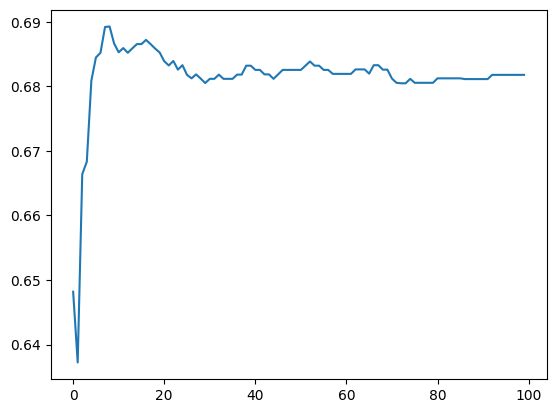

In [23]:
plt.plot(train_score[1])